In [1]:
import os
import json
import math
import random
import itertools
import numpy as np
import networkx as nx
import tqdm as tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from protocols import MPC_protocol, MPG_protocol, SP_protocol
from graph import network, set_p_edge

from networkx.algorithms.community import greedy_modularity_communities
from networkx.drawing.layout import *



In [2]:
mkr = ['x','+','d','o','1','2']+['x']*100
dashs = ['-.','--',':','-']+['-']*100
cols = ['gray','g','b','orange','r','k','purple']+['k']*100
linewidth = 2.2
mks = 5.5
fontsize = 14

Find the ER for the MPC, MPG, and SP protocols

In [3]:
# size = 5
# G =  network(size,size) # i.e. 6 x 6 networkx graph
# nodes = list(G.nodes)

In [4]:
def load_data():
    pos = {}
    user = []

    # Step 1: 读取 JSON 文件
    filepath = Path.cwd().parent.joinpath('graphs_json','class_0', 'TOP_104_USA100.json')
    with open(filepath, "r") as f:
        data = json.load(f)

    # Step 2: 初始化图
    G = nx.Graph()

    # Step 3: 添加节点

    for node in data["nodes"]:
        node_id = node["id"]
        x, y = node["latitude"], node["longitude"]
        G.add_node(node_id, location=node["location"], country=node["country"])  # 添加节点到图
        pos[node_id] = (y, x)  # 保存节点位置，注意 (longitude, latitude)

    # Step 4: 添加边
    for edge in data["links"]:
        source = int(edge["source"])
        target = int(edge["target"])
        G.add_edge(source, target, length=edge["length"])  # 添加边到图

    degree_dict = dict(G.degree())
    degree_items = list(degree_dict.items())
    first_node,first_degree = degree_items[0]
    print(f"First node ID: {first_node}, Degree: {first_degree}")

    user.append(data["nodes"][0]["id"])
    for item in itertools.islice(reversed(list(data["nodes"])), first_degree):
        user.append(item['id'])
    print(user)
    return G,user,pos

In [5]:
def multi_iterative_score_partition(
    G, 
    fixed_node, 
    alpha=1.0, 
    beta=1.0,
    max_rounds=10,
    shuffle_nodes=True
):
    """
    多轮迭代版“打分 + 搬家”分社区：
      - 社区数 = degree(fixed_node) + 1
      - 初始:0号社区放 fixed_node,其余每个邻居一个社区
      - 分配时:score = alpha * distance + beta * community_size
      - 多轮:如果搬家能让节点的score降低,就搬家,直到稳定或max_rounds

    参数:
        G (nx.Graph): 输入图
        fixed_node (int): 固定节点
        alpha (float): 距离权重
        beta (float): 社区规模权重
        max_rounds (int): 最大迭代轮数
        shuffle_nodes (bool): 每轮是否随机打乱节点遍历顺序

    返回:
        communities (List[Set]): 列表长度 = degree(fixed_node) + 1,
                                 第0个 = {fixed_node},
                                 第 i+1 个 = 第 i 个邻居的社区。
    """

    # 1) 根据固定节点度数 => 准备社区容器
    neighbors = list(G.neighbors(fixed_node))
    num_communities = len(neighbors)
    communities = [set() for _ in range(num_communities + 1)]
    visited = set()

    # 第0个社区放 fixed_node
    communities[0].add(fixed_node)
    visited.add(fixed_node)

    # 其余邻居各一个社区
    for i, nb in enumerate(neighbors, start=1):
        communities[i].add(nb)
        visited.add(nb)

    # 2) 初始化: 单轮分配 - 把剩余节点分配到“初次”score最小的社区
    for node in G.nodes():
        if node not in visited:
            best_score = float('inf')
            best_index = None
            for i, nb in enumerate(neighbors, start=1):
                dist = nx.shortest_path_length(G, source=node, target=nb)
                size = len(communities[i])
                score = alpha * dist + beta * size
                if score < best_score:
                    best_score = score
                    best_index = i
            communities[best_index].add(node)
            visited.add(node)

    # 3) 多轮迭代搬家
    round_num = 0
    while round_num < max_rounds:
        round_num += 1
        moved_count = 0

        # 获取所有节点（除 fixed_node 外），看要不要搬家
        # 如果要包括 fixed_node、看你需求，一般不建议移动它
        all_nodes = [n for n in G.nodes() if n != fixed_node]

        # 是否随机打乱节点遍历顺序？
        if shuffle_nodes:
            random.shuffle(all_nodes)

        for node in all_nodes:
            # 当前所在社区 idx
            current_idx = None
            for i, comm in enumerate(communities):
                if node in comm:
                    current_idx = i
                    break

            # 算一下“当前score”
            if current_idx == 0:
                # 如果你不想让 fixed_node 也搬家，就直接 continue
                # 这里示例：fixed_node是社区0，不搬家
                continue

            nb_current = neighbors[current_idx - 1] if current_idx > 0 else fixed_node
            dist_current = nx.shortest_path_length(G, source=node, target=nb_current)
            size_current = len(communities[current_idx])
            current_score = alpha * dist_current + beta * size_current

            # 尝试搬去别的社区，看score是否更低
            best_score = current_score
            best_index = current_idx

            for i, nb in enumerate(neighbors, start=1):
                if i == current_idx:
                    continue  # 跳过自己
                dist = nx.shortest_path_length(G, source=node, target=nb)
                size = len(communities[i])
                score = alpha * dist + beta * size

                if score < best_score:
                    best_score = score
                    best_index = i
            
            # 如果找到更好的社区 => 搬家
            if best_index != current_idx:
                communities[current_idx].remove(node)
                communities[best_index].add(node)
                moved_count += 1

        print(f"Round {round_num}: moved {moved_count} nodes")

        # 如果没有节点搬家 => 收敛 => 停止
        if moved_count == 0:
            break

    # 打印最终结果
    print("\nFinal communities after iterative refinement:")
    for i, comm in enumerate(communities):
        print(f"Community {i} (size={len(comm)}): {sorted(comm)}")
    
    return communities

def draw_colored_communities(G, communities, pos):
    """
    绘制带分区颜色的图，节点位置由指定的 pos 参数固定。

    参数:
        G (networkx.Graph): 输入图
        communities (list of sets): 每个社区的节点集合
        pos (dict): 每个节点的坐标位置，格式 {node: (x, y)}
    """
    # 颜色列表，用于区分社区
    colors = ["red", "blue", "green", "orange", "purple", "cyan", "yellow", "pink"]
    
    plt.figure(figsize=(8, 6))
    
    # 绘制每个社区
    for i, community in enumerate(communities):
        nx.draw_networkx_nodes(
            G, pos, nodelist=community,
            node_color=colors[i % len(colors)], 
            label=f"Community {i + 1}", alpha=0.8
        )
    
    # 绘制边
    nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.5)

    # 绘制节点标签
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

    # 添加图例
    plt.legend()
    plt.title("Graph with Colored Communities")
    plt.show()

First node ID: 39, Degree: 6
[39, 1, 3, 2, 5, 6, 4]


  0%|          | 0/50 [00:00<?, ?it/s]d:\Anaconda\Lib\site-packages\networkx\utils\decorators.py:770: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn' in version 3.2.
Set the `method` kwarg to remove this warning.
  return argmap._lazy_compile(__wrapper)(*args, **kwargs)
f:\Third-year\Third-year project\quantum_repeaters_testing\simplequantnetsim\protocols.py:125: FutureWarning: steiner_tree will change default method from 'kou' to 'mehlhorn' in version 3.2.
Set the `method` kwarg to remove this warning.
  K = steiner_tree(
100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


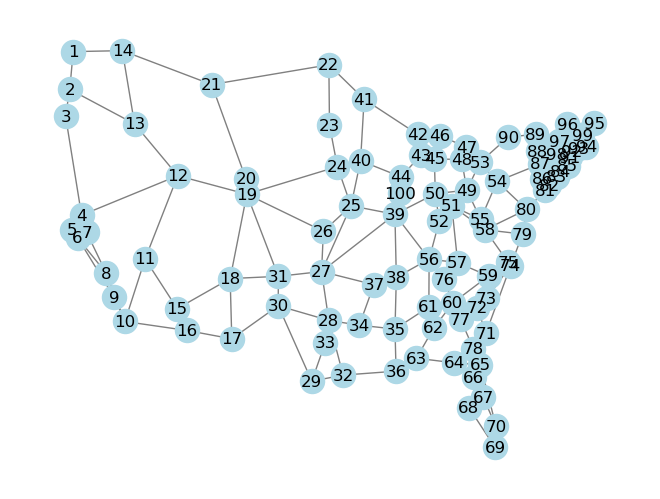

In [6]:
funcs= [MPC_protocol,MPG_protocol,SP_protocol]
p_range = np.linspace(1, 0.2, 50)

timesteps = 10
reps = 20
ER = np.zeros((len(funcs),len(p_range)))
G,users,pos = load_data()
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray")
G = network(G)


for i,p in enumerate(tqdm.tqdm(p_range)):# tqdm_notebook
    set_p_edge(G,p_op = p)
    for j,function in enumerate(funcs):
        er,multipartite_gen_time, links_used = function(G,users,timesteps=timesteps,reps=reps)
        ER[j,i]+=er


## plot Figure

Round 1: moved 12 nodes
Round 2: moved 10 nodes
Round 3: moved 2 nodes
Round 4: moved 4 nodes
Round 5: moved 4 nodes
Round 6: moved 9 nodes
Round 7: moved 3 nodes
Round 8: moved 6 nodes
Round 9: moved 4 nodes
Round 10: moved 2 nodes

Final communities after iterative refinement:
Community 0 (size=1): [39]
Community 1 (size=17): [1, 3, 4, 5, 8, 9, 10, 14, 19, 21, 22, 23, 24, 25, 26, 40, 41]
Community 2 (size=18): [2, 6, 7, 11, 12, 13, 15, 16, 17, 18, 20, 27, 28, 29, 30, 31, 32, 33]
Community 3 (size=13): [34, 35, 36, 37, 38, 63, 64, 65, 66, 67, 68, 69, 70]
Community 4 (size=27): [45, 46, 47, 48, 49, 50, 53, 54, 55, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Community 5 (size=4): [42, 43, 44, 100]
Community 6 (size=20): [51, 52, 56, 57, 58, 59, 60, 61, 62, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]


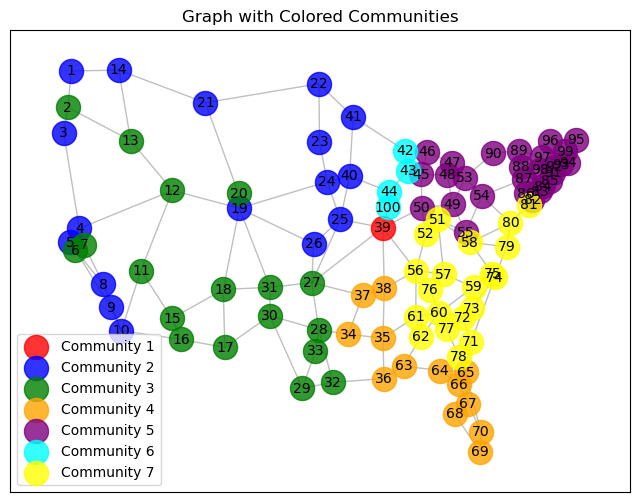

In [7]:
alpha = 1.4
beta = 0.105
communities = multi_iterative_score_partition(G, users[0],alpha,beta)
draw_colored_communities(G,communities,pos)

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Aaron\AppData\Local\Temp\ipykernel_18576\117633624.py:18: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)',fontsize=fontsize)


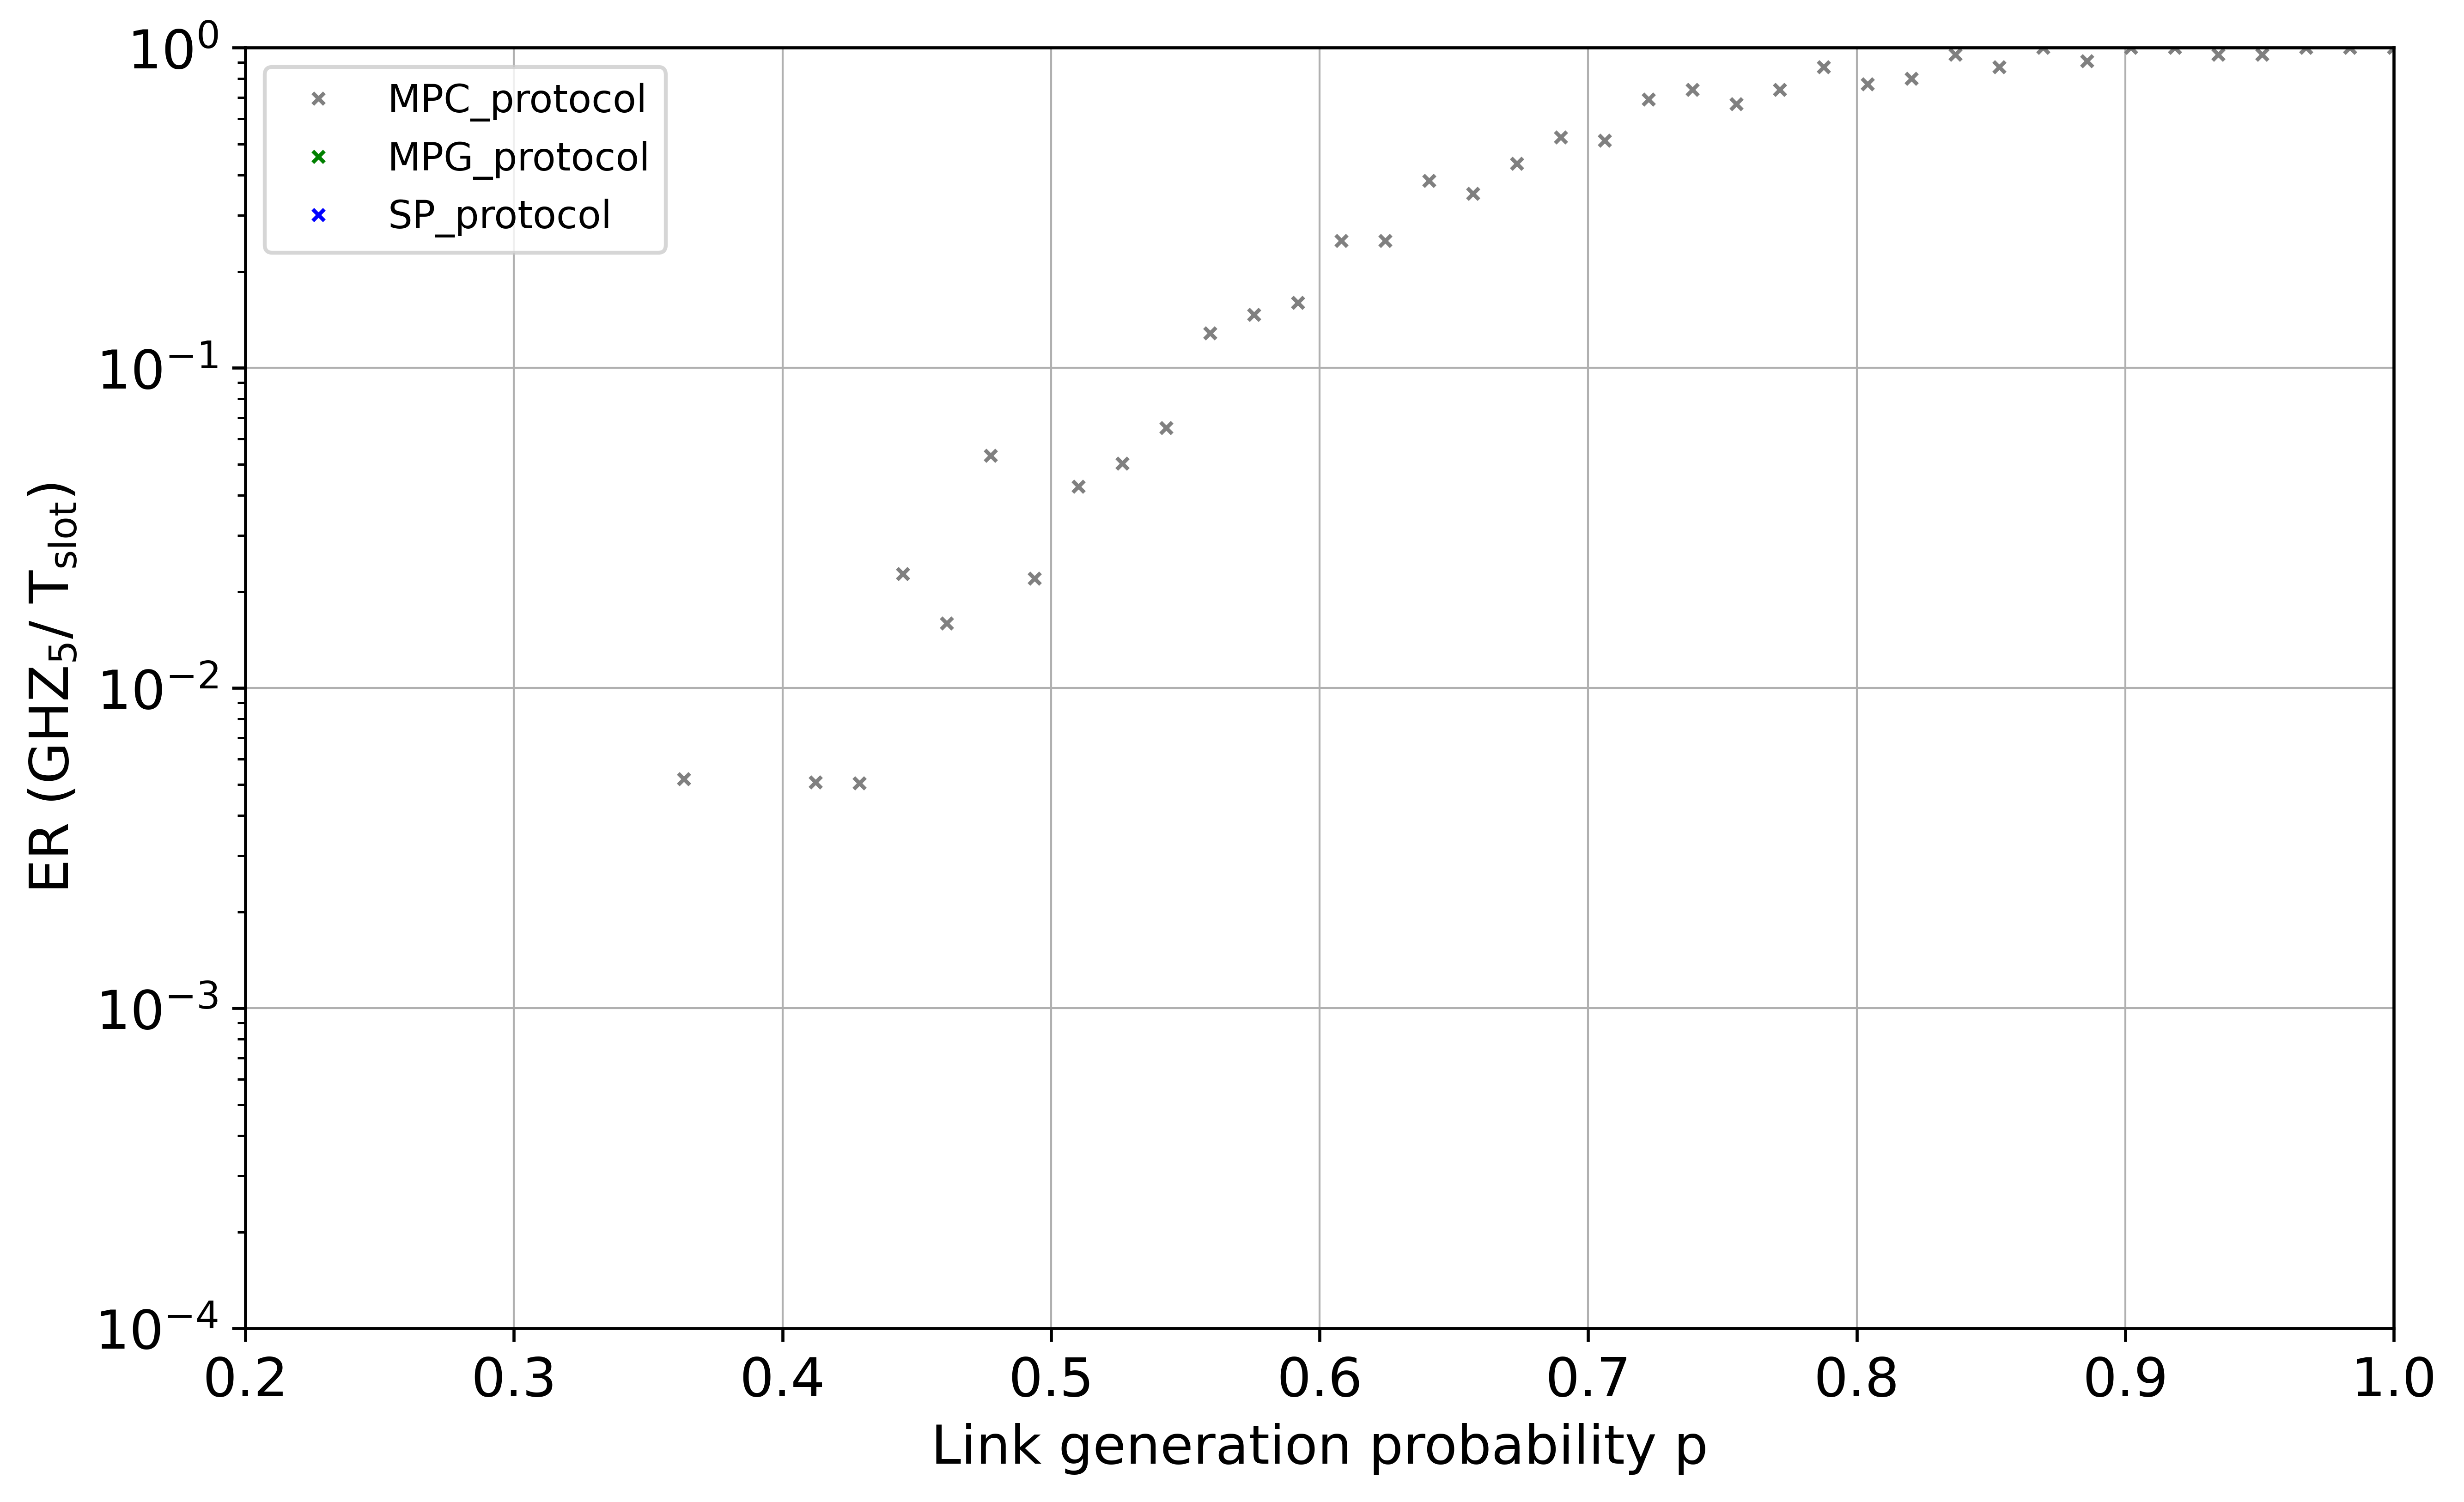

In [8]:

nom_list = [str(f).split(' ')[1] for f in funcs]
plt.figure(figsize =(10,6),dpi=600 )
plt.grid(linewidth=0.5)
for i in range(len(funcs)):
    y = plt.plot(p_range, ER[i],
                 color = cols[i],
                 marker = "x",
                 linestyle='None',
                 markersize = 3,
                #  alpha = 0.5,
                #  linewidth=linewidth,
                 label = nom_list[i])
plt.yscale('log')
plt.legend(fontsize=10)
plt.tick_params(labelsize=fontsize)

plt.xlabel('Link generation probability p',fontsize=fontsize)
plt.ylabel('ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)',fontsize=fontsize)

ax = plt.gca()
ax.set_xlim([0.2, 1])
ax.set_ylim([0.0001, 1])

save_path = Path.cwd().parent.joinpath("result","class_0")
plt.savefig(save_path.joinpath('ER_v_p.png'), dpi=600)